### Project Description.
The following project aims to use a hypothetical scenario to exercise knowledge and practice in Product Analytics, as well as develop a deeper understanding of the data generation process underlying user behavior of a mobile app. 

The data is generated using Python and the Faker library due to the lack of publicly available datasets on mobile app data and user behavior.

The scenario considers Tranquility, a company whose mission is to democratize access to mental health services by providing low-cost mental health courses and therapist services. 

The company operates under a freemium model where paying members have access to an unlimited number of courses in mental health.

The company launched their mobile app with user access to courses in July 2021 and have a respectable 20,000 paying customers. They are however, receiving feedback from their customers that they'd like more guidance in achieving their own personal mental health and wellbeing goals while they complete their courses.

The company therefore brainstorms ideas and decides to launch a therapist service, allowing users to receive weekly guided support from specialist mentors in multiple areas of mental health and wellbeing including stress management, happinness coaching, and so on. 

The company launches their therapist service in July 2023. It has been 3 months (the date is now September 2023) since the company has launched their therapist service and they are now looking to assess whether the launch has been a success.

The new company model will seek to operate under a platform business model where they bring together patients and therapists; the patients seeking mental health support and the therapists seeking new patients.

Courses are offered with the purpose of enabling the individual to make strong progress in the therapeutic process before being matched with a therapist. This allows the overall number of hours spent with the therapist to be reduced, and an overall decrease in overhead costs, thereby making therapy more accessible.

The purpose of this project will therefore be to assess two main questions:
- Has the offering of course service achieved product-market fit?
- Has the launch of the therapist service has been a success or not. 



### Data Assumptions.
In order to add some complexity and realism to the dataset, we will make some assumptions on the parameters of the dataset and its distributions.

Pricing.
- Users pay a flat subscription fee of 10 per month for access to all courses. This is known as Course Access.
- Users pay an extra 20 per month flat subscription fee for access to weekly review sessions with a therapist. This is known as the Therapist Service.
- Users can choose from 3 price plans for Course Access:
   - Monthly. 10 dollars a month.
   - Yearly. 90 dollars a year.
   - Lifetime. 300 dollars.
- Randomize the distribution of Users choosing each individual price plan. The guideline is that most will be monthly, some will be yearly, and few will be lifetime.

Therapist service.
- Users need to be paying members of the Course Access in order to access the Therapist Service. It is not possible for someone to access the Therapist service without first paying for the Course Access.
- Upon sign-up to the service, users are assigned a therapist. The selection of the therapist is dependent on the courses the user has signed-up for. 
- The service runs parallel to the courses where users pay a monthly subscription fee for access to weekly 1:1 sessions with their mentor at a duration of approximately 1 hour, give or take a variance of 5 minutes, with greater likelihood of exceeding time.
- If the user is unhappy with their therapist, they may request a new one. Users get a maximum of 2 requests, after which there is an official review process to assess why the user may not be happy with the mentors. 
- Users have the opportunity to review therapists after each session and at the end of the month.  
- There are 10 different specialisation categories occupied by therapists. Each therapist can only list their 3 specializations, ranked by level of expertise.
- Therapist reviews should have a strong negative skew - i.e. most of the reviews should be 3 or higher, with the majority being 4, and some being 5.

Courses.
- There are 10 courses, each specialising within a particular domain of mental health - i.e. Relationships, Stress Management, and so on.
- Free trial Course Access users only have access to trial 1 course.
- Paying Course Access users have access to an unlimited number of courses.
- Paying Therapist Service users, whilst using the Therapist Service however, are limited to 3 courses at a time. This encourages users to not take on too much at once and risk the outcome of not completing the courses. This also enables the therapist that has been assigned to the user to be able to effectively guide them in their requested topics. 
- Courses are 30 minutes long.
- Most of the courses are completed in either the morning between 7:00 and 9:00, or the evening between 21:00 and 23:00.

User.
- Randomize the function mapping the distribution of the user base growth for both the Course Access and the Therapist service. The trend should overall increase, but the specific trajectory should be based on a randomized function.
- User split is is distributed between paying and non-paying.

# Assessment.

Quantitative indicators of product-market-fit
- Churn rate < 20 % = high likelihood of either on the way to PMF, or at PMF
- 


In [15]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from faker import Faker
import random

fake = Faker()

# Constants
N_USERS = 20000
N_THERAPISTS = 1000
N_COURSES = 10
N_COURSE_PLANS = 3
N_THERAPIST_SPECIALIZATIONS = 10

# Pricing plans
COURSE_PLANS = ['Monthly', 'Yearly', 'Lifetime']
COURSE_PRICES = [10, 90, 300]

# Helper functions
def skewed_normal(mean, std_dev, skewness):
    return skewness * np.random.normal(loc=0, scale=1, size=1)[0] + np.random.normal(loc=mean, scale=std_dev, size=1)[0]

# Generate random signups over 2 years
days = pd.date_range(start='1/1/2021', end='12/31/2023', freq='D')

def sigmoid_function(t, L, k, x0):
    return L / (1 + np.exp(-k * (t - x0)))

# t values should be from -0.5 to 0.5 for a nice sigmoid curve
t = np.linspace(-0.5, 0.5, len(days))

# Generating the signups_per_day array using the sigmoid function
# We adjust k to get the right growth speed and L to get the right maximum number of users
signups_per_day = sigmoid_function(t, L=N_USERS*10, k=20, x0=0)
signups_per_day = np.round(signups_per_day)

# Generate data
signups = np.random.choice(days, size=N_USERS, p=signups_per_day/np.sum(signups_per_day))
users = pd.DataFrame({
    'user_id': range(N_USERS),
    'subscription_date': signups,
    'is_paying': np.random.choice([True, False], size=N_USERS, p=[0.05, 0.95]),
})

users['course_plan'] = [np.random.choice(COURSE_PLANS, p=[0.7, 0.2, 0.1]) if is_paying else 'Non-Paying' for is_paying in users['is_paying']]
users['uses_therapy'] = [is_paying and (subscription_date >= pd.Timestamp('2023-09-01')) and bool(random.getrandbits(1)) for is_paying, subscription_date in zip(users['is_paying'], users['subscription_date'])]

courses = pd.DataFrame({
    'course_id': range(N_COURSES),
    'course_name': [fake.catch_phrase() for _ in range(N_COURSES)]
})

therapists = pd.DataFrame({
    'therapist_id': range(N_THERAPISTS),
    'specialization_1': [random.randint(1, N_THERAPIST_SPECIALIZATIONS) for _ in range(N_THERAPISTS)],
    'specialization_2': [random.randint(1, N_THERAPIST_SPECIALIZATIONS) for _ in range(N_THERAPISTS)],
    'specialization_3': [random.randint(1, N_THERAPIST_SPECIALIZATIONS) for _ in range(N_THERAPISTS)],
})

course_completions = pd.DataFrame({
    'user_id': [uid for uid in range(N_USERS) for _ in range(5)],  # Assuming each user completes 5 courses on average
    'course_id': [random.randint(0, N_COURSES-1) for _ in range(N_USERS * 5)],
    'completion_time': [fake.date_between_dates(date_start=(users.loc[uid, 'subscription_date']).date(), date_end=(users.loc[uid, 'subscription_date'] + timedelta(days=random.randint(1, 30))).date()) for uid in range(N_USERS) for _ in range(5)],
})

therapy_sessions = pd.DataFrame({
    'user_id': [uid for uid in users.loc[users['uses_therapy'] == True, 'user_id'].tolist() for _ in range(4)],  # Assuming each therapy user has 4 sessions on average
    'therapist_id': [random.randint(0, N_THERAPISTS-1) for _ in range(int(sum(users['uses_therapy']) * 4))],
    'session_time': [fake.date_between_dates(date_start=(users.loc[uid, 'subscription_date'] + timedelta(days=1)).date(), date_end=(users.loc[uid, 'subscription_date'] + timedelta(days=90)).date()) for uid in users.loc[users['uses_therapy'] == True, 'user_id'].tolist() for _ in range(4)],
    'session_duration': [random.randint(55, 65) for _ in range(int(sum(users['uses_therapy']) * 4))],  # Session duration in minutes
    'review_score': [skewed_normal(4, 1, -0.5) for _ in range(int(sum(users['uses_therapy']) * 4))],
    'therapist_change_request': [random.randint(0, 2) for _ in range(int(sum(users['uses_therapy']) * 4))],
})

In [3]:
users.head()

,user_id,subscription_date,is_paying,course_plan,course_price,uses_therapy
0,0,2023-03-03,False,Non-Paying,0,False
1,1,2023-12-15,False,Non-Paying,0,False
2,2,2023-08-12,False,Non-Paying,0,False
3,3,2023-04-22,False,Non-Paying,0,False
4,4,2022-09-28,False,Non-Paying,0,False


In [12]:
courses.head()

,course_id,course_name
0,0,Distributed clear-thinking time-frame
1,1,Programmable maximized artificial intelligence
2,2,Multi-lateral bandwidth-monitored workforce
3,3,Profound multi-state Graphical User Interface
4,4,Integrated solution-oriented ability


In [14]:
therapists.head()

,therapist_id,specialization_1,specialization_2,specialization_3
0,0,9,1,5
1,1,6,8,4
2,2,6,4,1
3,3,4,9,7
4,4,6,5,6


In [15]:
course_completions.head()

,user_id,course_id,completion_time
0,3397,7,2023-01-25 08:28:59
1,4497,7,2022-07-03 17:26:54
2,4879,4,2023-03-12 10:44:16
3,9191,9,2022-07-02 17:24:06
4,3443,7,2023-01-16 02:44:29


In [16]:
therapy_sessions.head()

,user_id,therapist_id,session_time,session_duration,review_score,therapist_change_request
0,5,737,2023-03-25 15:12:57,64,1.085651,2
1,5,849,2023-04-02 00:20:56,65,2.883079,1
2,5,281,2023-04-03 04:48:24,59,2.815514,0
3,5,591,2023-05-23 06:04:28,63,5.383732,1
4,8,321,2023-03-29 23:38:51,60,4.790380,0


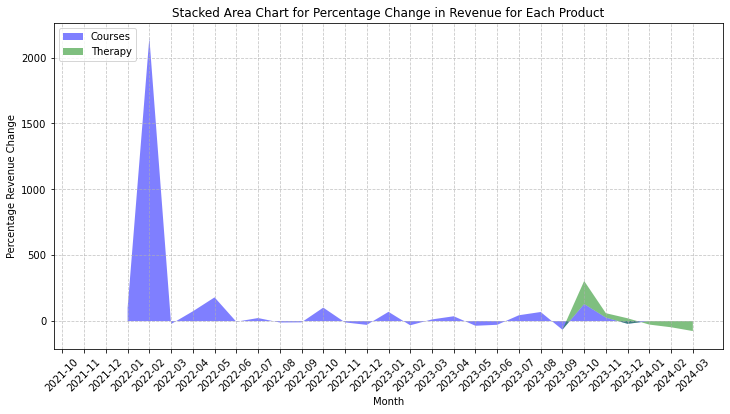

In [12]:
import matplotlib.pyplot as plt

# Assuming each therapy session costs 50 units
THERAPY_SESSION_COST = 50

# Calculate Monthly Revenue for Courses
users['subscription_month'] = users['subscription_date'].dt.to_period('M')
monthly_course_revenue = users.groupby('subscription_month')['course_price'].sum()

# Calculate Monthly Revenue for Therapy
therapy_sessions['session_month'] = pd.to_datetime(therapy_sessions['session_time']).dt.to_period('M')
monthly_therapy_revenue = therapy_sessions.groupby('session_month').size() * THERAPY_SESSION_COST

# Calculate the Percentage Revenue Change for Courses
monthly_course_revenue_diff = monthly_course_revenue.diff().dropna()
monthly_course_revenue_percent_change = ((monthly_course_revenue_diff / monthly_course_revenue.shift(1)) * 100).dropna()

# Calculate the Percentage Revenue Change for Therapy
monthly_therapy_revenue_diff = monthly_therapy_revenue.diff().dropna()
monthly_therapy_revenue_percent_change = ((monthly_therapy_revenue_diff / monthly_therapy_revenue.shift(1)) * 100).dropna()

# Align indices for both products
all_months = monthly_course_revenue_percent_change.index.union(monthly_therapy_revenue_percent_change.index)
monthly_course_revenue_percent_change = monthly_course_revenue_percent_change.reindex(all_months, fill_value=0)
monthly_therapy_revenue_percent_change = monthly_therapy_revenue_percent_change.reindex(all_months, fill_value=0)

# Plotting
plt.figure(figsize=(12, 6))

# Stacked Area Chart
plt.stackplot(monthly_course_revenue_percent_change.index.astype(str),
              monthly_course_revenue_percent_change.values,
              monthly_therapy_revenue_percent_change.values,
              labels=['Courses', 'Therapy'],
              alpha=0.5, colors=['blue', 'green'])

plt.xlabel('Month')
plt.ylabel('Percentage Revenue Change')
plt.title('Stacked Area Chart for Percentage Change in Revenue for Each Product')
plt.xticks(rotation=45)
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

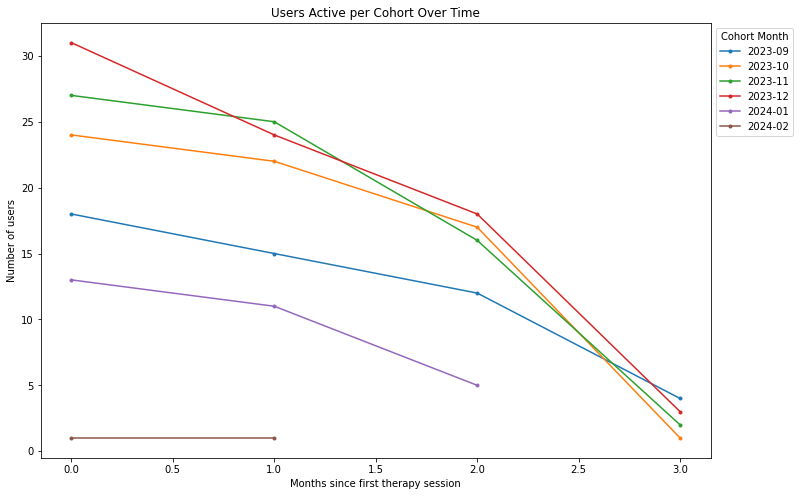

In [8]:
import matplotlib.pyplot as plt
from operator import attrgetter
import pandas as pd  # Import this if you haven't

# Explicitly convert the 'session_time' column to datetime
therapy_sessions['session_time'] = pd.to_datetime(therapy_sessions['session_time'])

# Getting the month of the first session for each user
therapy_sessions['cohort_month'] = therapy_sessions.groupby('user_id')['session_time'].transform('min').dt.to_period('M')

# Number of periods since the first therapy session for each user
therapy_sessions['period_number'] = (therapy_sessions.session_time.dt.to_period('M') - therapy_sessions.cohort_month).apply(attrgetter('n'))

# Creating a DataFrame to hold the cohort and period data
cohort_data = therapy_sessions.groupby(['cohort_month', 'period_number']).user_id.nunique().reset_index()

# Pivoting the data to get it in the wide format, which makes it easier to plot
cohort_pivot = cohort_data.pivot(index='cohort_month', columns='period_number', values='user_id')

# Transpose the DataFrame, so the cohorts become columns and periods become rows
cohort_pivot = cohort_pivot.T

# Plotting the cohorts over time
plt.figure(figsize=(12,8))

for column in cohort_pivot.columns:
    plt.plot(cohort_pivot.index, cohort_pivot[column], marker='.', label=str(column))

plt.title('Users Active per Cohort Over Time')
plt.xlabel('Months since first therapy session')
plt.ylabel('Number of users')
plt.legend(title='Cohort Month', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

course_logs: user_id, course_id, modules_completed (1 - 4), completion_time
therapy_logs: user_id, therapist_id, session_time, review_score, therapist_change_request

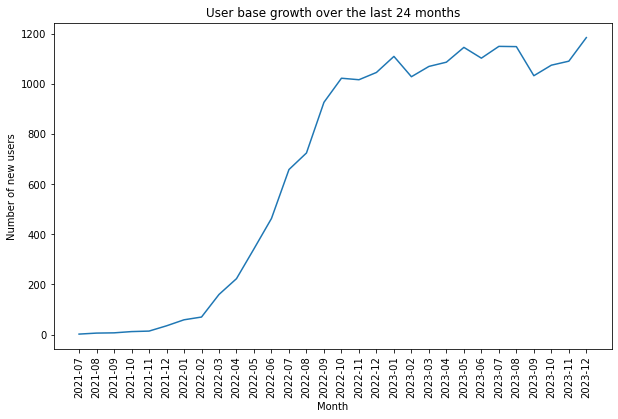

In [46]:
# How has the user base grown in the past 2 years?

# Convert subscription_date to datetime
users['subscription_date'] = pd.to_datetime(users['subscription_date'])

# Filter the users who subscribed in the last 24 months
start_date = datetime.now() - pd.DateOffset(months=24)
users_last_24_months = users[users['subscription_date'] >= start_date]

# Group by month and count unique user ids
user_growth = users_last_24_months.groupby(users_last_24_months['subscription_date'].dt.to_period('M')).nunique()['user_id']

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(user_growth.index.astype(str), user_growth.values)

plt.title("User base growth over the last 24 months")
plt.xlabel("Month")
plt.ylabel("Number of new users")
plt.xticks(rotation=90) # Rotate the x-axis labels for better visibility

plt.show()

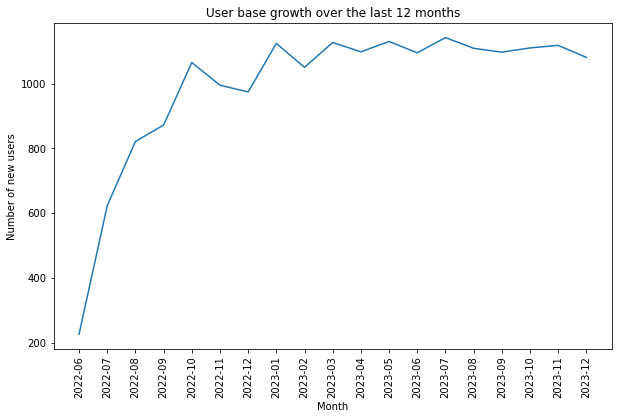

In [26]:
# How has the user base grown in the past year?

# Convert subscription_date to datetime
users['subscription_date'] = pd.to_datetime(users['subscription_date'])

# Filter the users who subscribed in the last 24 months
start_date = datetime.now() - pd.DateOffset(months=12)
users_last_12_months = users[users['subscription_date'] >= start_date]

# Group by month and count unique user ids
user_growth = users_last_12_months.groupby(users_last_12_months['subscription_date'].dt.to_period('M')).nunique()['user_id']

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(user_growth.index.astype(str), user_growth.values)

plt.title("User base growth over the last 12 months")
plt.xlabel("Month")
plt.ylabel("Number of new users")
plt.xticks(rotation=90) # Rotate the x-axis labels for better visibility

plt.show()

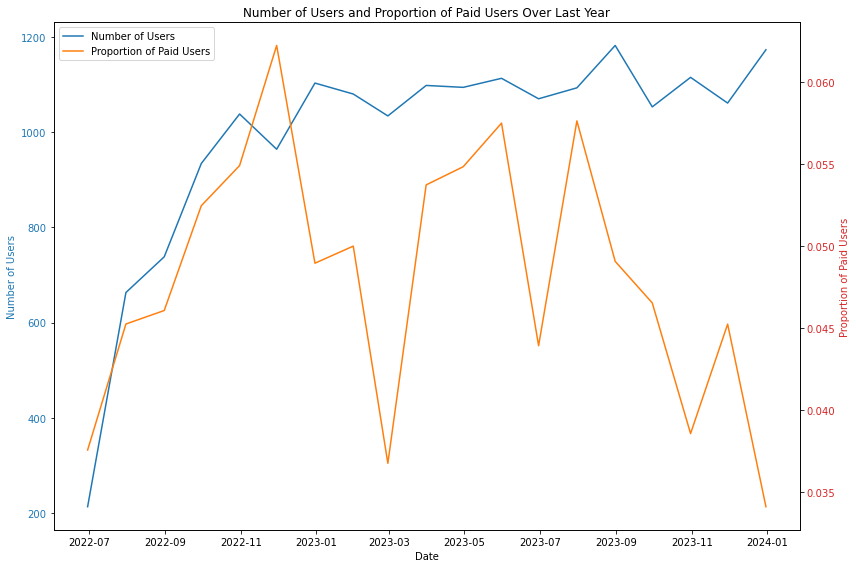

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Define the date a year ago from now
year_ago = datetime.now() - timedelta(days=365)

# Filter data for the last year only
users_last_year = users[users['subscription_date'] >= year_ago]

# Resample the subscription dates to monthly frequency
monthly_users = users_last_year.resample('M', on='subscription_date').count()['user_id']

# Calculate the proportions of paid users for each month
monthly_users_paid = users_last_year[users_last_year['is_paying'] == True].resample('M', on='subscription_date').count()['user_id']
monthly_users_paid_prop = monthly_users_paid / monthly_users

# Plotting
fig, ax1 = plt.subplots(figsize = (12, 8))


color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Users', color=color)
line1, = ax1.plot(monthly_users.index, monthly_users.values, color=color, label='Number of Users')  # Added label
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
color = 'tab:red'
ax2.set_ylabel('Proportion of Paid Users', color=color)
line2, = ax2.plot(monthly_users.index, monthly_users_paid_prop, color='tab:orange', label='Proportion of Paid Users')  # Added label
ax2.tick_params(axis='y', labelcolor=color)

# Added title and legend
plt.title('Number of Users and Proportion of Paid Users Over Last Year')
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

fig.tight_layout()
plt.show()